### 0. Imports

In [2]:
import tqdm
from vae import VAE
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt

### 1. Set up

In [6]:
!pip install ipywidgets
content_path = './notebooks'
data_path = './data/'

In [21]:
def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path + '/VAE/'):
    os.makedirs(content_path + '/VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# Set a random seed to ensure that results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = False
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("mps")
print(f'Using {device}')

Using mps


### 2. Load data

In [22]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 256


train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path + '/VAE/image_original.png')

### 3. Set hyperparameters for the encoder and decoder

In [54]:
latent_dims = 2
encoder_hyper_params = {
    "latent_dims": latent_dims,
    "hidden_channels": [24, 24, 24, 24],
    "kernels": [3, 3, 3, 3],
    "strides": [1, 2, 2, 1],
    "paddings": [1, 1, 1, 1],
    "in_channels": 1,
    "fc_neurons": 24 * 49
}

decoder_hyper_params = {
    "in_channels": 24,
    "hidden_channels": [24, 24, 24, 6],
    "kernels": [3, 4, 4, 4],
    "strides": [1, 2, 2, 1],
    "paddings": [0, 0, 0, 0],
    "out_channels": 1,
    "final_kernel": 4,
    "final_stride": 1,
    "final_padding": 0,
    "final_output_padding": 0
}

***Set hyperparameters for the learning process***

In [67]:
num_epochs = 25
learning_rate = 5E-4

### 4. Train the VAE

***Define the loss function***

In [56]:
def loss_function_VAE(recon_x, x, mu, logvar, beta):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum') # Sigmoid
    kl_divergence = - 0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).sum()
    loss = recon_loss + beta*kl_divergence
    return loss, recon_loss, kl_divergence

***Store results***

In [80]:
plots = []
betas = [0.3]
models = []

***Training loop***

In [61]:
def step(data, training=True):
    data = data.to(device)
    optimizer.zero_grad()
    recon_x, x, mu, logvar = model(data)
    loss, bce_loss, kld_loss = loss_function_VAE(recon_x, x, mu, logvar, beta)
    if training:
        loss.backward()
        optimizer.step()
    return loss, kld_loss, bce_loss

In [68]:
model = VAE(encoder_hyper_params=encoder_hyper_params,
            decoder_hyper_params=decoder_hyper_params)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for beta in betas:
    plotting_dict = {
    "train_total_loss": [],
    "train_KLD": [],
    "train_bce": [],
    "test_total_loss": [],
    "test_KLD": [],
    "test_bce": [],
    }
    for epoch in range(num_epochs):
        total_loss_mean = 0
        kld_mean = 0
        bce_mean = 0
        model.train()
        with tqdm.tqdm(loader_train, unit="batch") as tepoch:
            for batch_idx, (data, _) in enumerate(tepoch):
                loss, kld_loss, bce_loss = step(data)
                total_loss_mean += loss.detach().item()
                kld_mean += kld_loss.detach().item()
                bce_mean += bce_loss.detach().item()
                if batch_idx % 20 == 0:
                    tepoch.set_description(f"Epoch {epoch}")
                    tepoch.set_postfix(loss=loss.item()/len(data))

        plotting_dict["train_total_loss"].append(total_loss_mean/len(loader_train))
        plotting_dict["train_bce"].append(bce_mean/len(loader_train))
        plotting_dict["train_KLD"].append(kld_mean/len(loader_train))

        total_loss_mean = 0
        kld_mean = 0
        bce_mean = 0
        model.eval()

        for batch_idx, (data, _) in enumerate(loader_test):
            loss, kld_loss, bce_loss = step(data, training=False)
            total_loss_mean += loss.detach().item()
            kld_mean += kld_loss.detach().item()
            bce_mean += bce_loss.detach().item()

        plotting_dict["test_total_loss"].append(total_loss_mean/len(loader_test))
        plotting_dict["test_bce"].append(bce_mean/len(loader_test))
        plotting_dict["test_KLD"].append(kld_mean/len(loader_test))
        #######


        # save the model
        if epoch == num_epochs - 1 and beta == 3:
            with torch.no_grad():
                torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                    content_path/f'VAE/VAE_model_beta={beta}.pth')
    plots.append(plotting_dict)
    models.append(model)

Epoch 24: 100%|██████████| 235/235 [00:11<00:00, 20.07batch/s, loss=150]


## Latent Space viz

2


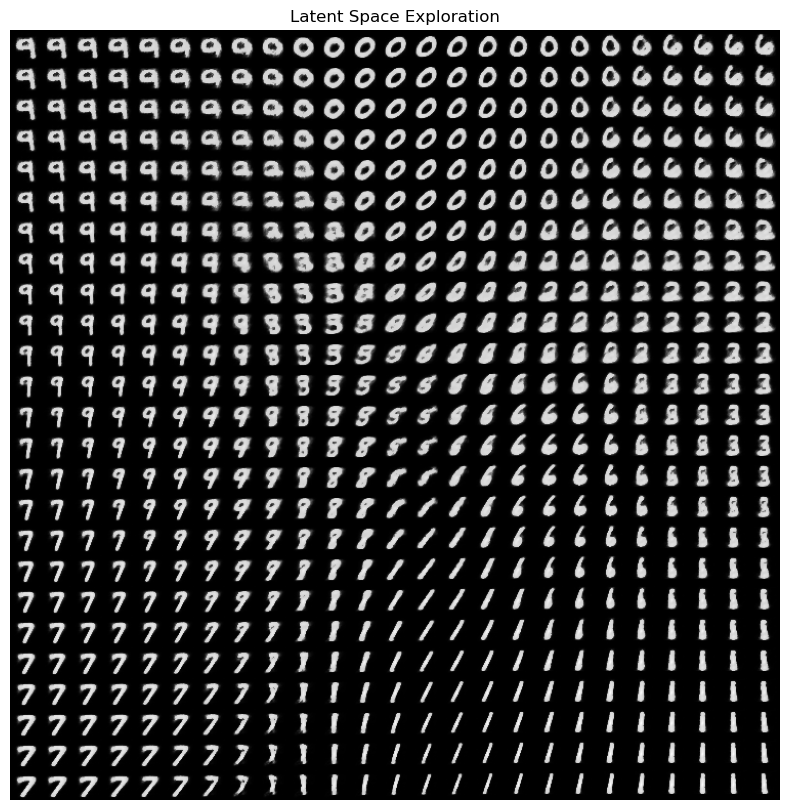

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define a grid for the latent space
grid_size = 25  # Number of points per latent dimension
latent_dims = model.latent_dims  # Replace with the actual latent dimension
range_min, range_max = -2, 2  # Sampling range for latent space
grid_points = np.linspace(range_min, range_max, grid_size)
print(model.latent_dims)

# Generate a grid of latent vectors for 2D exploration (assume latent_dims=2 for simplicity)
if latent_dims == 2:
    z1, z2 = np.meshgrid(grid_points, grid_points)
    latent_grid = np.stack([z1.ravel(), z2.ravel()], axis=-1)  # Shape: (grid_size^2, 2)
else:
    raise ValueError("Latent space visualization works best for latent_dims=2.")

# Convert latent grid to tensor
latent_grid = torch.tensor(latent_grid, dtype=torch.float32).to(device)

# Decode latent grid points
with torch.no_grad():
    generated_images = model.decode(latent_grid)  # Shape: (grid_size^2, C, H, W)

# Arrange images in a grid for visualization
generated_images = generated_images.cpu()
image_grid = make_grid(generated_images, nrow=grid_size, padding=2, normalize=True)

# Visualize the grid
plt.figure(figsize=(10, 10))
plt.imshow(image_grid.permute(1, 2, 0).numpy())  # Convert CHW -> HWC for plotting
plt.axis('off')
plt.title("Latent Space Exploration")
plt.show()


2


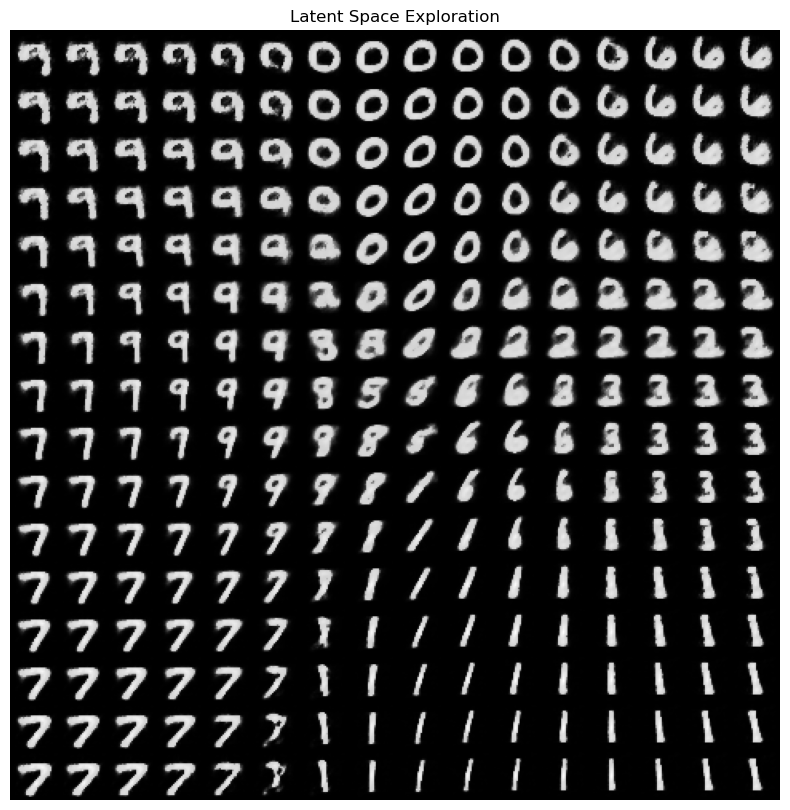

In [69]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Define a grid for the latent space
grid_size = 16  # Number of points per latent dimension
latent_dims = model.latent_dims  # Replace with the actual latent dimension
range_min, range_max = -3, 3  # Sampling range for latent space
grid_points = np.linspace(range_min, range_max, grid_size)
print(model.latent_dims)

# Generate a grid of latent vectors for 2D exploration (assume latent_dims=2 for simplicity)
if latent_dims == 2:
    z1, z2 = np.meshgrid(grid_points, grid_points)
    latent_grid = np.stack([z1.ravel(), z2.ravel()], axis=-1)  # Shape: (grid_size^2, 2)
else:
    raise ValueError("Latent space visualization works best for latent_dims=2.")

# Convert latent grid to tensor
latent_grid = torch.tensor(latent_grid, dtype=torch.float32).to(device)

# Decode latent grid points
with torch.no_grad():
    generated_images = model.decode(latent_grid)  # Shape: (grid_size^2, C, H, W)

# Arrange images in a grid for visualization
generated_images = generated_images.cpu()
image_grid = make_grid(generated_images, nrow=grid_size, padding=2, normalize=True)

# Visualize the grid
plt.figure(figsize=(10, 10))
plt.imshow(image_grid.permute(1, 2, 0).numpy())  # Convert CHW -> HWC for plotting
plt.axis('off')
plt.title("Latent Space Exploration")
plt.show()


### Samples from the VAE

Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


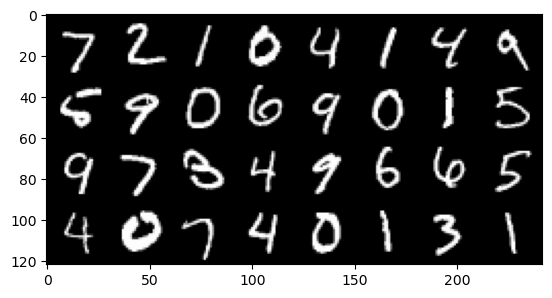

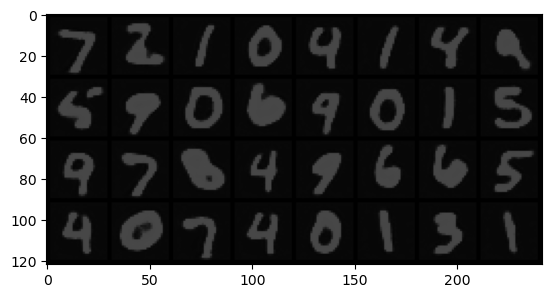

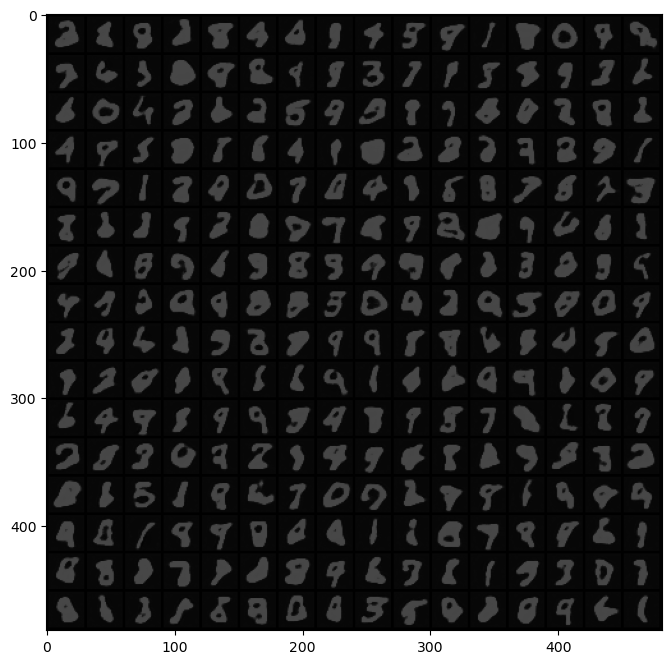

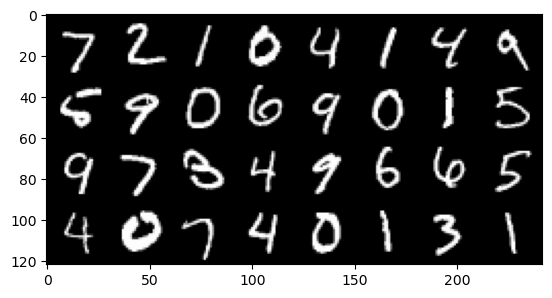

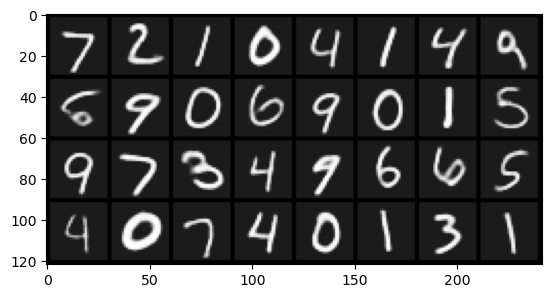

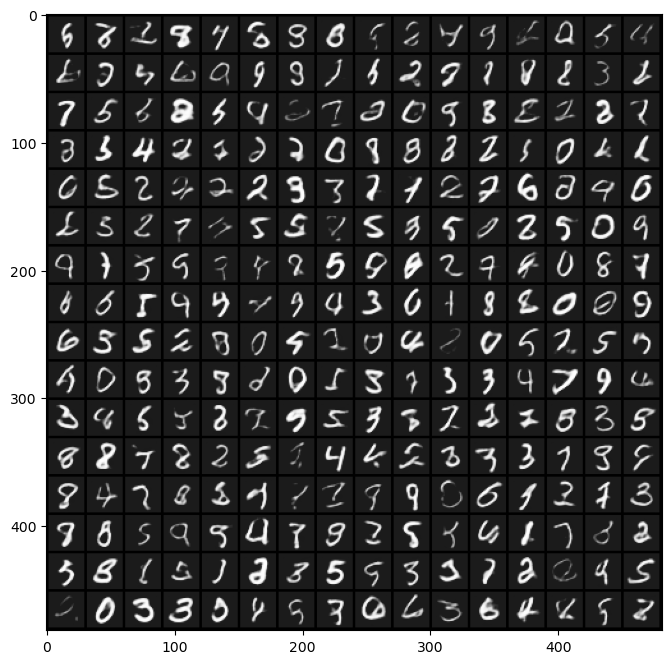

In [52]:
print('Input images')
print('-'*50)
for i, model in enumerate(models):
    sample_inputs, _ = next(iter(loader_test))
    fixed_input = sample_inputs[0:32, :, :, :]
    # visualize the original images of the last batch of the test set
    img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                     scale_each=False, pad_value=0)
    plt.figure()
    show(img)
    #print(f'*** BETA = {betas[i]} ***')
    print('Reconstructed images')
    print('-'*50)
    with torch.no_grad():
        fixed_input = fixed_input.to(device)
        recon_batch, _, _, _ = model(fixed_input)
        recon_batch = recon_batch.cpu()
        recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                                scale_each=False, pad_value=0)
        plt.figure()
        show(recon_batch)

    print('Generated Images')
    print('-'*50)
    model.eval()
    n_samples = 256
    z = torch.randn(n_samples,latent_dims).to(device)
    with torch.no_grad():
        samples = model.decode(z)
        samples = samples.cpu()
        samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
        plt.figure(figsize = (8,8))
        show(samples)



Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


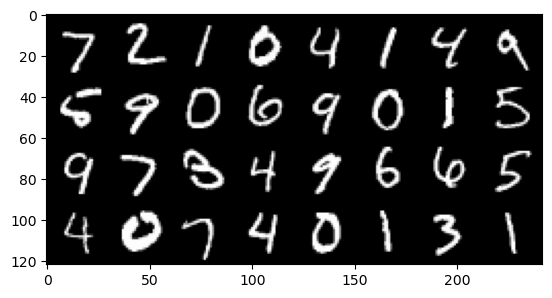

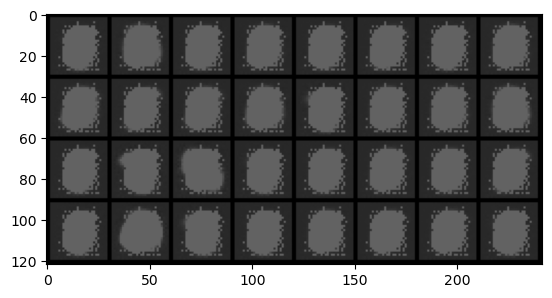

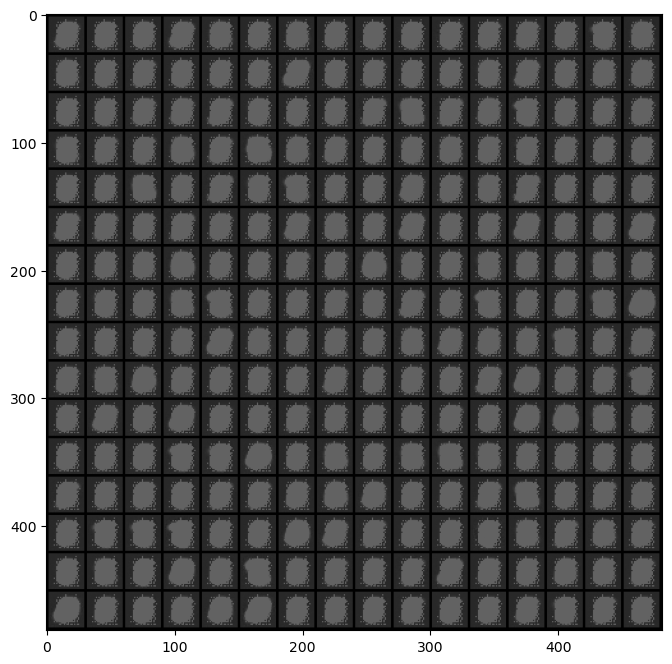

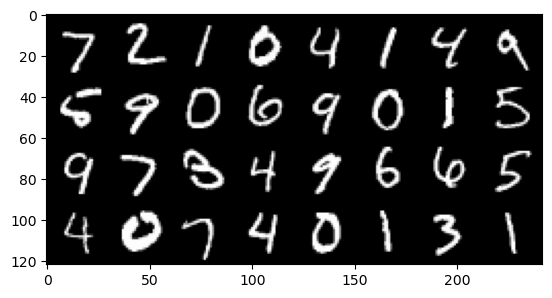

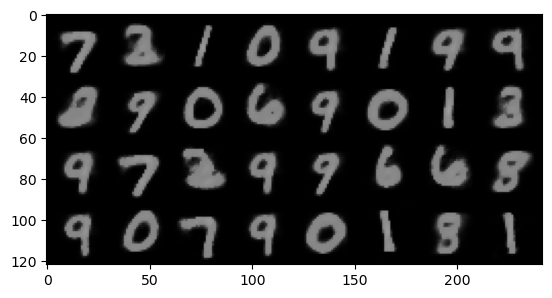

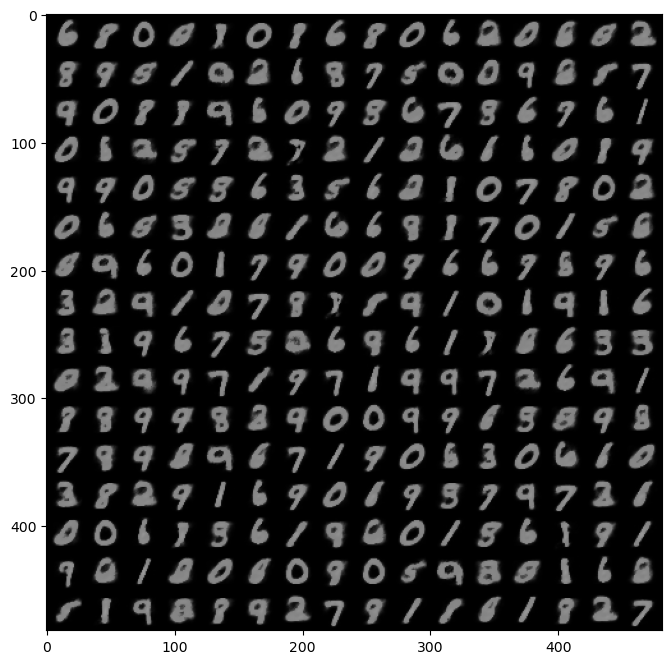

In [72]:
print('Input images')
print('-'*50)
for i, model in enumerate(models):
    sample_inputs, _ = next(iter(loader_test))
    fixed_input = sample_inputs[0:32, :, :, :]
    # visualize the original images of the last batch of the test set
    img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                     scale_each=False, pad_value=0)
    plt.figure()
    show(img)
    #print(f'*** BETA = {betas[i]} ***')
    print('Reconstructed images')
    print('-'*50)
    with torch.no_grad():
        fixed_input = fixed_input.to(device)
        recon_batch, _, _, _ = model(fixed_input)
        recon_batch = recon_batch.cpu()
        recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                                scale_each=False, pad_value=0)
        plt.figure()
        show(recon_batch)

    print('Generated Images')
    print('-'*50)
    model.eval()
    n_samples = 256
    z = torch.randn(n_samples,latent_dims).to(device)
    with torch.no_grad():
        samples = model.decode(z)
        samples = samples.cpu()
        samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
        plt.figure(figsize = (8,8))
        show(samples)



Input images
--------------------------------------------------
*** BETA = [0.3] ***
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------
*** BETA = [0.3] ***
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


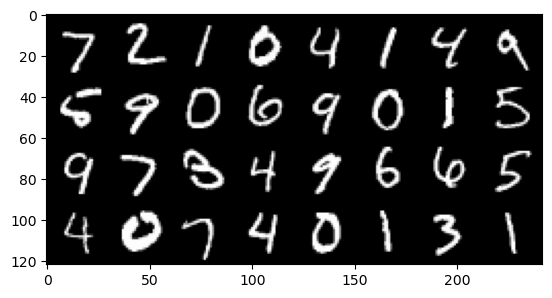

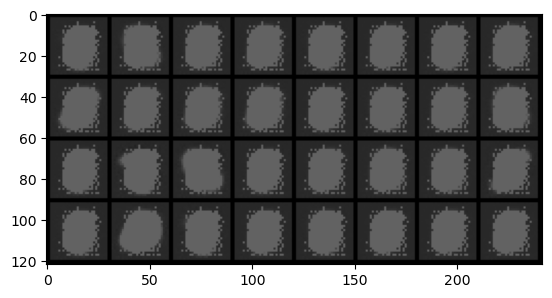

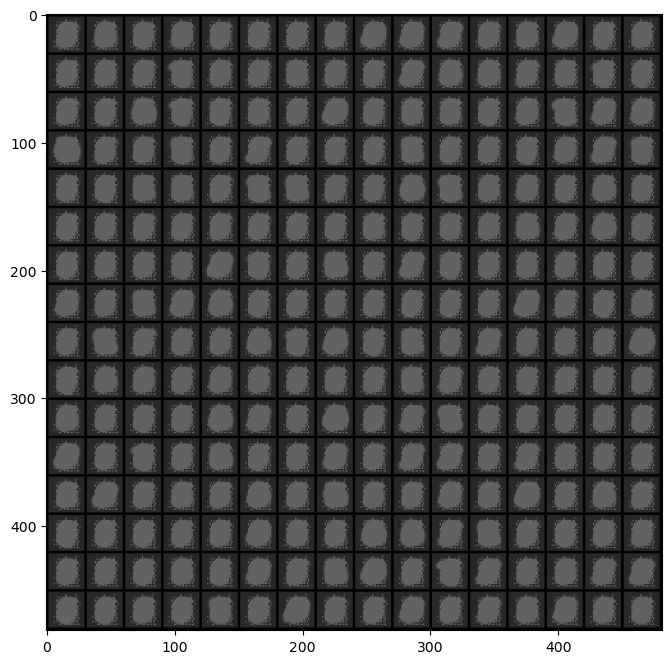

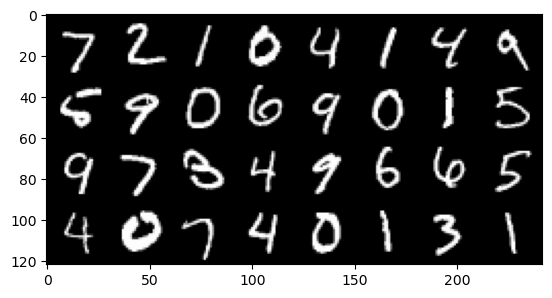

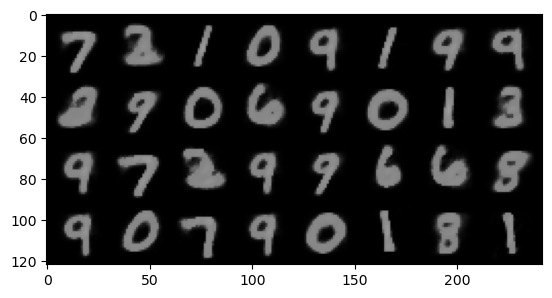

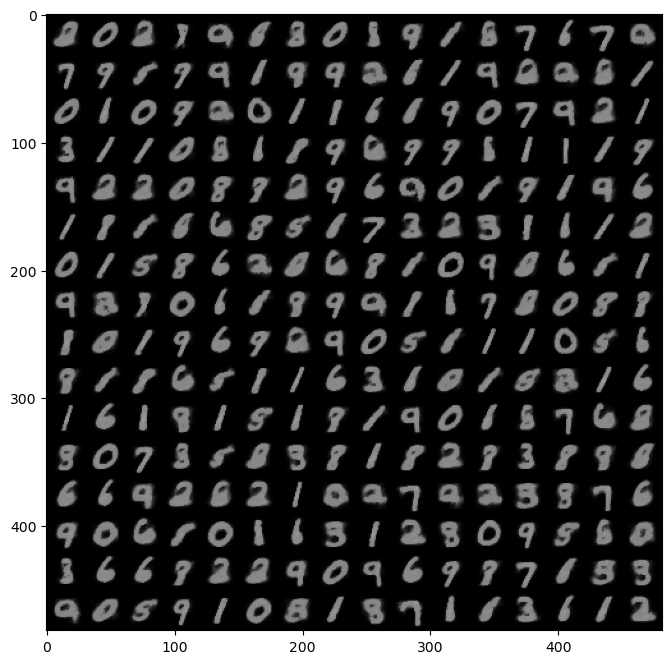

In [78]:
print('Input images')
print('-'*50)
for i, model in enumerate(models):
    sample_inputs, _ = next(iter(loader_test))
    fixed_input = sample_inputs[0:32, :, :, :]
    # visualize the original images of the last batch of the test set
    img = make_grid(fixed_input, nrow=8, padding=2, normalize=False,
                    scale_each=False, pad_value=0)
    plt.figure()
    show(img)
    print(f'*** BETA = {betas} ***')
    print('Reconstructed images')
    print('-'*50)
    with torch.no_grad():
        fixed_input = fixed_input.to(device)
        recon_batch, _, _, _ = model(fixed_input)
        recon_batch = recon_batch.cpu()
        recon_batch = make_grid(recon_batch, nrow=8, padding=2, normalize=False,
                                scale_each=False, pad_value=0)
        plt.figure()
        show(recon_batch)

    print('Generated Images')
    print('-'*50)
    model.eval()
    n_samples = 256
    z = torch.randn(n_samples,latent_dims).to(device)
    with torch.no_grad():
        samples = model.decode(z)
        samples = samples.cpu()
        samples = make_grid(samples, nrow=16, padding=2, normalize=False,
                            scale_each=False, pad_value=0)
        plt.figure(figsize = (8,8))
        show(samples)

